# counting

In [ ]:
def count_comments(data):
    # Iterate over the 'stories' list within the data dictionary
    return len(data['stories']), sum(len(story['kids_text']) for story in data['stories'])

## github projects only

In [ ]:
import json

HN_COMMENTS_JSON = ''
with open(HN_COMMENTS_JSON) as f:
    data = json.load(f)

num_stories, num_comments = count_comments(data)
print(f"Total number of stories: {num_stories}")
print(f"Total number of comments: {num_comments}")

Total number of stories: 4645
Total number of comments: 78541


## all discussions

In [ ]:
HN_COMMENTS_GH_JSON = ''
with open(HN_COMMENTS_GH_JSON) as f:
    data = json.load(f)

num_stories, num_comments = count_comments(data)
print(f"Total number of stories: {num_stories}")
print(f"Total number of comments: {num_comments}")

Total number of stories: 4645
Total number of comments: 78541


# convert from json to csv

## setup methods

In [ ]:
import json
import csv
import html
from datetime import datetime
import re
from bs4 import BeautifulSoup

def read_json_file(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def extract_github_urls(text):
    github_url_pattern = r"https://github\.com/[a-zA-Z0-9-]+/[a-zA-Z0-9-_.]+(?:/(?:issues|pull)/\d+)?"
    return list(set(re.findall(github_url_pattern, text)))

def is_github_repo_or_issue(url):
    if not url.startswith("https://github.com/"):
        return "Not GitHub"
    if "/issues/" in url:
        return "GitHub Issue"
    if "/pull/" in url:
        return "GitHub PR"
    return "GitHub Repo"

def unix_to_datetime(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')

def clean_html(html_text):
    if html_text is None:
        return ''
    soup = BeautifulSoup(html_text, 'html.parser')
    return soup.get_text(separator=' ', strip=True)

def flatten_comments(comments, discussion_id, title, url, discussion_date, parent_id=None, depth=0):
    flattened = []
    if not isinstance(comments, list):
        print(f"Warning: comments is not a list. Type: {type(comments)}")
        return flattened

    for i, comment in enumerate(comments):
        if not isinstance(comment, dict):
            print(f"Warning: comment {i} is not a dict. Type: {type(comment)}")
            continue

        comment_id = comment.get('id', '')
        comment_text = comment.get('text')
        if comment_text is None:
            print(f"Warning: comment {comment_id} has None text")
            comment_text = ''
        else:
            comment_text = clean_html(comment_text)
        comment_date = unix_to_datetime(comment.get('time', 0))
        comment_author = comment.get('author', '')

        flattened.append({
            'discussion_id': discussion_id,
            'title': title,
            'url': url,
            'discussion_date': discussion_date,
            'comment_id': comment_id,
            'parent_id': parent_id,
            'depth': depth,
            'comment_text': comment_text,
            'comment_date': comment_date,
            'comment_author': comment_author,
        })

        children = comment.get('children', [])
        if isinstance(children, list):
            flattened.extend(flatten_comments(children, discussion_id, title, url, discussion_date, comment_id, depth + 1))
        else:
            print(f"Warning: children for comment {comment_id} is not a list. Type: {type(children)}")

    return flattened

def process_stories(discussions):
    rows = []
    github_urls = set()

    for i, discussion in enumerate(discussions['stories']):
        discussion_id = discussion.get('id')
        title = discussion.get('title', '')
        url = discussion.get('url', '')
        discussion_date = unix_to_datetime(discussion.get('time', 0))

        print(f"Processing discussion {i+1}: ID {discussion_id}, Title: {title[:30]}...")

        github_urls.update(extract_github_urls(title))
        github_urls.update(extract_github_urls(url))

        comments_hierarchy = discussion.get('kids_text', None)
        if comments_hierarchy is not None:
            # print(f"  Found {len(comments_hierarchy)} top-level comments")
            for j, comment in enumerate(comments_hierarchy):
                comment_text = comment.get('text', 'N/A')
                comment_text_preview = comment_text[:30] if comment_text is not None else 'None'
                # print(f"    Comment {j+1}: ID {comment.get('id', 'N/A')}, Author: {comment.get('author', 'N/A')}, Text: {comment_text_preview}...")
            rows.extend(flatten_comments(comments_hierarchy, discussion_id, title, url, discussion_date))
        else:
            # print("  No comments found for this discussion")
            rows.append({
                'discussion_id': discussion_id,
                'title': title,
                'url': url,
                'discussion_date': discussion_date,
                'comment_id': '',
                'parent_id': '',
                'depth': 0,
                'comment_text': '',
                'comment_date': '',
                'comment_author': '',
            })

    print(f"Processed {len(discussions['stories'])} discussions, found {len(rows)} total comments")
    return rows, github_urls

def write_csv(filename, data, fieldnames):
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)


## github projects only

In [ ]:
hn_comments_data = read_json_file(HN_COMMENTS_GH_JSON)

comments_rows, comments_github_urls = process_stories(hn_comments_data)

fieldnames = [
    'discussion_id',
    'title',
    'url',
    'discussion_date',
    'comment_id',
    'parent_id',
    'depth',
    'comment_text',
    'comment_date',
    'comment_author',
]

write_csv(HN_COMMENTS_GH_CSV, comments_rows, fieldnames)

## all discussions

In [ ]:
HN_COMMENTS_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq1/rq1_comments_all.csv'

In [ ]:

hn_comments_data = read_json_file(HN_COMMENTS_JSON)

comments_rows, comments_github_urls = process_stories(hn_comments_data)

fieldnames = [
    'discussion_id',
    'title',
    'url',
    'discussion_date',
    'comment_id',
    'parent_id',
    'depth',
    'comment_text',
    'comment_date',
    'comment_author',
]

write_csv(HN_COMMENTS_CSV, comments_rows, fieldnames)

Processing discussion 1: ID 31342409, Title: AI-engineered enzyme eats enti...
Processing discussion 2: ID 31355348, Title: BlindAI: Open-source, fast and...
Processing discussion 3: ID 31365053, Title: Employers’ Use of AI Tools Can...
Processing discussion 4: ID 31390564, Title: Breaking into the black box of...
Processing discussion 5: ID 31405976, Title: OpenAI Codex Python to C++ Cod...
Processing discussion 6: ID 31409566, Title: AI recognition of patient race...
Processing discussion 7: ID 31412110, Title: AI and Machine Learning – The ...
Processing discussion 8: ID 31412608, Title: Show HN: AI generated Magic Th...
Processing discussion 9: ID 31421232, Title: Show HN: Natural Language Proc...
Processing discussion 10: ID 31451114, Title: An AI system for solving cross...
Processing discussion 11: ID 31468284, Title: AI-art isn't art: DALL-E and o...
Processing discussion 12: ID 31477741, Title: Founders Resign at Mycroft.ai...
Processing discussion 13: ID 31486590, Title: I ma

<ipython-input-11-8554a7bd0907>:31: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


Streaming output truncated to the last 5000 lines.
Processing discussion 1512: ID 35741921, Title: AI Is a Waste of Time...
Processing discussion 1513: ID 35743664, Title: Launch Lamini: The LLM Engine ...
Processing discussion 1514: ID 35743727, Title: Stability AI releases DeepFloy...
Processing discussion 1515: ID 35744974, Title: Nuke-launching AI would be ill...
Processing discussion 1516: ID 35745682, Title: Stability AI releases StableVi...
Processing discussion 1517: ID 35746177, Title: Why I'm no longer writing stor...
Processing discussion 1518: ID 35748540, Title: OpenAI closes its monster $10B...
Processing discussion 1519: ID 35749306, Title: AI Will Rapidly Transform Labo...
Processing discussion 1520: ID 35750918, Title: Italy lifts ban on ChatGPT aft...
Processing discussion 1521: ID 35751276, Title: Study: ChatGPT outperforms phy...
Processing discussion 1522: ID 35752719, Title: We aren't close to creating a ...
Processing discussion 1523: ID 35754138, Title: Lawmaker

# show comments statistics

In [ ]:
import pandas as pd

def get_comment_statistics(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Group by 'discussion_id' and count the number of comments in each story
    comment_counts = df.groupby('discussion_id').size().reset_index(name='num_comments')

    # Calculate overall statistics
    total_stories = comment_counts['discussion_id'].nunique()
    total_comments = comment_counts['num_comments'].sum()
    max_comments = comment_counts['num_comments'].max()
    min_comments = comment_counts['num_comments'].min()
    avg_comments = comment_counts['num_comments'].mean()

    # Print the statistics
    print(f"Total number of stories: {total_stories}")
    print(f"Total number of comments: {total_comments}")
    print(f"Average number of comments per story: {avg_comments:.2f}")
    print(f"Max number of comments in a story: {max_comments}")
    print(f"Min number of comments in a story: {min_comments}")

    # Return the DataFrame containing the number of comments per story
    return comment_counts


In [ ]:
# Example usage:
comment_stats = get_comment_statistics(HN_COMMENTS_GH_CSV)
print(comment_stats)

Total number of stories: 348
Total number of comments: 4707
Average number of comments per story: 13.53
Max number of comments in a story: 98
Min number of comments in a story: 1
     discussion_id  num_comments
0         31355348             7
1         31405976             6
2         31846593            41
3         32458048            10
4         32628761            21
..             ...           ...
343       40226976             9
344       40237305             4
345       40252569            42
346       40285986             3
347       40291780             4

[348 rows x 2 columns]


In [ ]:
# Example usage:
comment_stats = get_comment_statistics(HN_COMMENTS_GH_CSV)
print(comment_stats)

Total number of stories: 218
Total number of comments: 383
Average number of comments per story: 1.76
Max number of comments in a story: 6
Min number of comments in a story: 1
     discussion_id  num_comments
0         31533180             2
1         31555920             2
2         31662560             2
3         31776740             1
4         31934400             1
..             ...           ...
213       40189560             1
214       40215100             1
215       40259100             1
216       40265420             1
217       40291780             1

[218 rows x 2 columns]


# plot no. comments per story

## setup methods

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_comment_distribution(csv_file):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Group by 'discussion_id' and count the number of comments in each story
    comment_counts = df.groupby('discussion_id').size().reset_index(name='num_comments')

    # Sort by number of comments for better visualization
    comment_counts = comment_counts.sort_values(by='num_comments', ascending=False)

    # Plotting the distribution of comments per story
    plt.figure(figsize=(10, 6))
    sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')

    # Set the plot title and labels
    plt.title('Number of Comments per Story (discussion_id)', fontsize=14)
    plt.xlabel('Discussion ID (Story)', fontsize=12)
    plt.ylabel('Number of Comments', fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)

    # Show the plot
    plt.tight_layout()
    plt.show()

C:\Users\prach\AppData\Local\Temp\ipykernel_23192\4014733331.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')


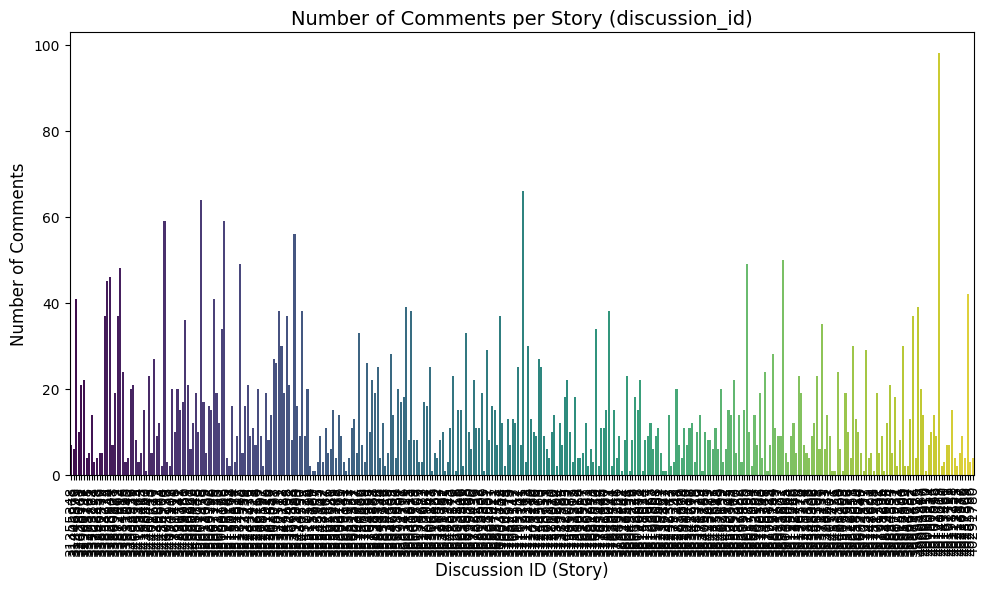

In [ ]:
# Example usage:
plot_comment_distribution(HN_COMMENTS_GH_CSV)

C:\Users\prach\AppData\Local\Temp\ipykernel_8860\4014733331.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='discussion_id', y='num_comments', data=comment_counts, palette='viridis')


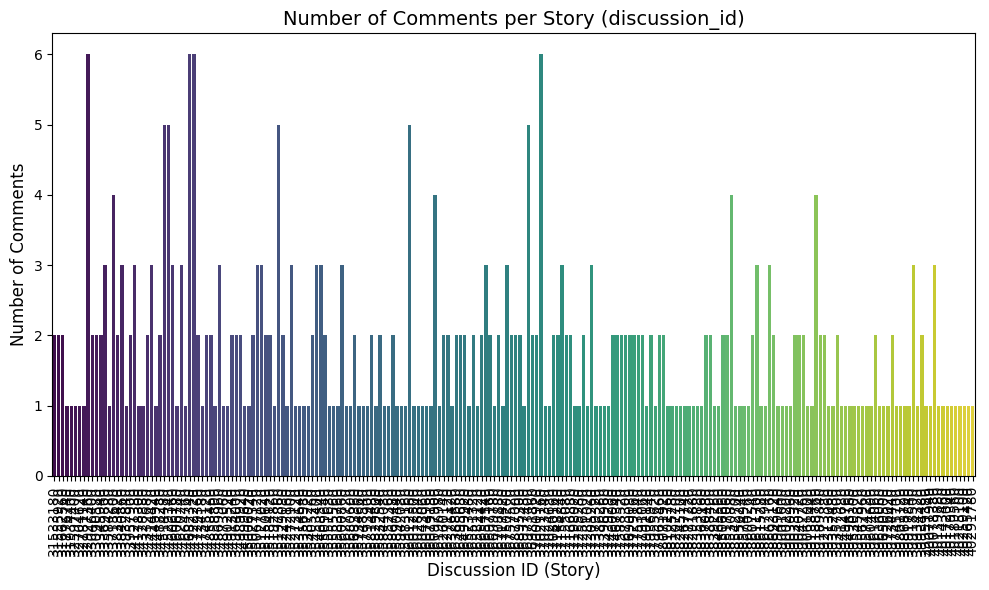

In [ ]:
# Example usage:
plot_comment_distribution(HN_COMMENTS_SAMPLED_CSV)

# plotting comment trend histogram

## setup method

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

plt.rcParams.update({'font.size': 18})

def plot_comments_histogram(title, csv_file_path, bin_size_days=7):
    """
    Plot a histogram of AI discussion comments over time from a CSV file.

    Args:
    title (str): graph title
    csv_file_path (str): The path to the CSV file.
    bin_size_days (int): The size of each bin in days.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Convert comment_date to datetime
    df['comment_date'] = pd.to_datetime(df['comment_date'])

    # Create the histogram
    fig, ax = plt.subplots(figsize=(15, 7))

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-09').timestamp()

    # Based on the start_id and end_id defined above
    total_days = (end_date - start_date) / (24*60*60)
    bins = int(total_days / bin_size_days)

    n, bins, patches = ax.hist(df['comment_date'], bins=bins, edgecolor='black')

    # Format x-axis ticks as dates
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

    # Set the number of ticks on the x-axis
    num_ticks = 12
    ax.xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator(maxticks=num_ticks))

    # plt.title(f'{title} (Bin Size: {bin_size_days} days)')
    plt.xlabel('Date')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=45)

    # Add vertical line for ChatGPT release
    chatgpt_release = pd.Timestamp('2022-11-30')
    plt.axvline(x=chatgpt_release, color='r', linestyle='--', label='ChatGPT Release')
    plt.legend()
    plt.grid(visible=True, alpha=0.7)

    plt.tight_layout()
    plt.show()


## github projects only

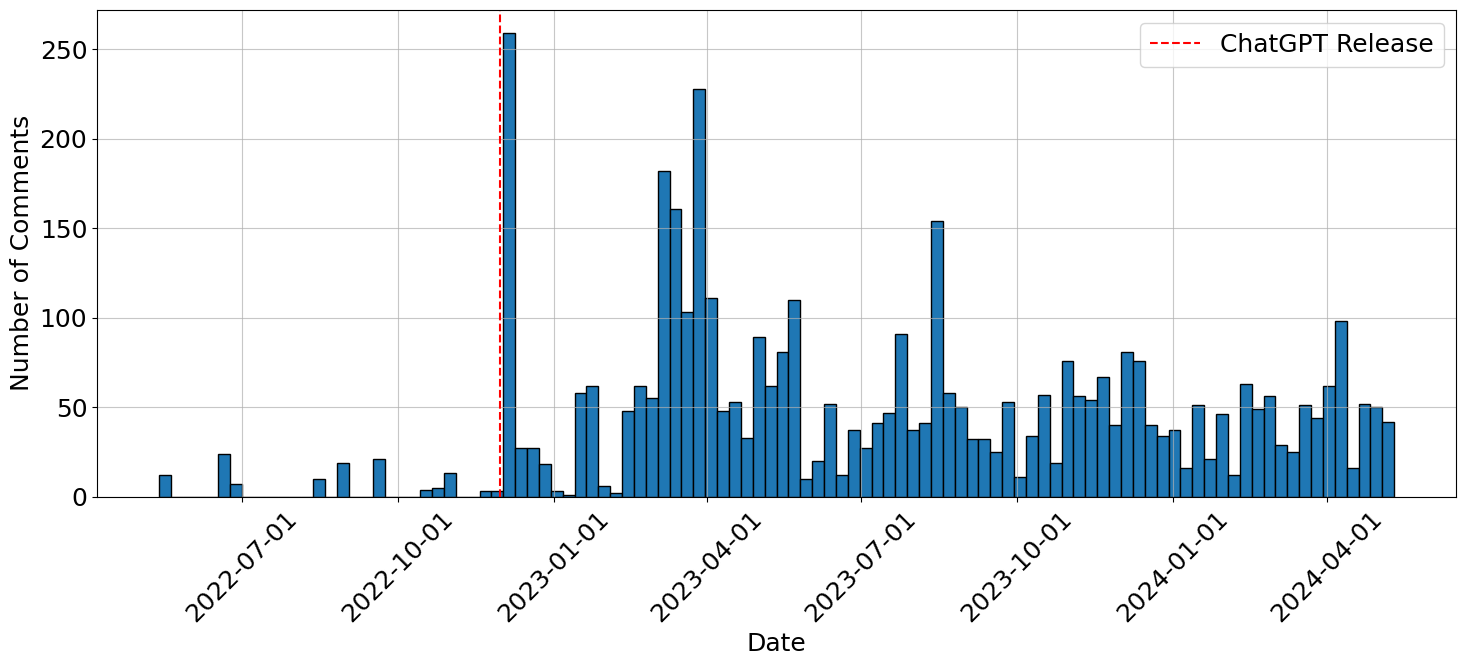

In [9]:
HN_COMMENTS_GH_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq1/rq1_freq_analysis/rq1_comments_github_clean.csv'
HN_COMMENTS_CSV = ''
plot_comments_histogram(
    # "HN Discussion comment trend histogram (GitHub projects only)",
    "",
    HN_COMMENTS_GH_CSV,
    bin_size_days=7)
# plot_comments_histogram("HN Discussion comment trend histogram (full)", HN_COMMENTS_CSV, bin_size_days=7)
# plot_comments_histogram("HN Discussion comment trend histogram (github projects only)", HN_COMMENTS_GH_CSV, bin_size_days=30)

# calculating trend statistics